![Cancer](https://media2.giphy.com/media/sCqnpiUFN228E/giphy.gif)

# Introduction

Among the most important areas in the world is human health. Exploring the methods for preventing and detecting health problems has sparked a lot of interest. Cancer is the most common illness that has a significant impact on human health. A malignant tumor is a cancerous tumor that develops as a result of the disease. Colon cancer, together with breast cancer and lung cancer, is the third most deadly disease in the United States, killing 49,190 people in 2016 [1]. This is a cancer that begins in the large intestine colon, which is the last component of the digestive system.

The machine learning technique should be used in this assignment to aid in the detection of malignant cells and the differentiation of cell types in colon cancer. Deep learning algorithms such as AlexNet, Resnet50, and VGG19 will all be developed and evaluated in this notebook, with XGBoost being the sole non-deep learning option to tackle the issue.

# Import necessary library

In [1]:
conda install -c conda-forge keras-preprocessing

Solving environment: done

## Package Plan ##

  environment location: /Users/bmhuyquoc104/opt/anaconda3

  added / updated specs:
    - keras-preprocessing


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.12.0               |   py39h6e9494a_0         1.0 MB  conda-forge
    keras-preprocessing-1.1.2  |     pyhd8ed1ab_0          34 KB  conda-forge
    python_abi-3.9             |           2_cp39           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.0 MB

The following NEW packages will be INSTALLED:

  keras-preprocessi~ conda-forge/noarch::keras-preprocessing-1.1.2-pyhd8ed1ab_0
  python_abi         conda-forge/osx-64::python_abi-3.9-2_cp39

The following packages will be SUPERSEDED by a higher-priority channel:

  conda              pkgs/main::conda-4.12.0-py39hecd8cb5_0 --> cond

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Load dataset

In [2]:
df_label = pd.read_csv("data_labels_mainData.csv")
df_label_extra = pd.read_csv("data_labels_extraData.csv")

## *Task1: Classify  images  according  to  whether  given  cell  image  represents  a cancerous cells or not (isCancerous)*

# Data Processing 


In [ ]:
is_cancer_class_count = df_label.isCancerous.value_counts()
amount_for_balance = abs(is_cancer_class_count[0] - is_cancer_class_count[1])
df_random_cancer_from_extra = df_label_extra[df_label_extra['isCancerous'] == 1].sample(amount_for_balance)
df_label = pd.concat([df_label, df_random_cancer_from_extra], ignore_index=True)
df_label.isCancerous.value_counts()

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_label, test_size=0.2, random_state=9999)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=9999)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))

In [ ]:
# document: https://keras.io/api/preprocessing/image/#imagedatagenerator-class
from keras_preprocessing.image import ImageDataGenerator

def get_dataframe_iterator(dataframe, 
                            image_shape = (27, 27), 
                            batch_size = 64,
                            x_col = "ImageName",
                            y_col = "cellTypeName",
                            classes = ["fibroblast", "inflammatory", "epithelial", "others"]):
    dataframe[y_col] = dataframe[y_col].apply(str)
    generator = ImageDataGenerator(
        rescale = 1./255, 
        rotation_range = 20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    ) 
    iterator = generator.flow_from_dataframe(
        dataframe = dataframe,
        directory = "./patch_images", 
        x_col = x_col,
        y_col = y_col,
        classes = classes, 
        class_mode = "categorical", 
        target_size = image_shape, 
        batch_size = batch_size,
    )
    return iterator

In [ ]:
train_iterator = get_dataframe_iterator(train_df, y_col='isCancerous', classes=['0','1'])
val_iterator = get_dataframe_iterator(val_df, y_col='isCancerous', classes=['0','1'])
test_iterator = get_dataframe_iterator(test_df, y_col='isCancerous', classes=['0','1'])

In [ ]:
# Check duplicate

In [ ]:
import hashlib, os
duplicates = []
hash_keys = dict()
for index, filename in  enumerate(os.listdir('./patch_images/')):  #listdir('.') = current directory
    if os.path.isfile('./patch_images/'+filename):
        with open('./patch_images/'+filename, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys: 
            hash_keys[filehash] = index
        else:
            duplicates.append((index,hash_keys[filehash]))
            print(filename)


In [ ]:
duplicates

In [ ]:
hash_keys

In [ ]:
file_list = os.listdir('./patch_images/')
print(file_list)

In [ ]:
conda install -c anaconda scipy==1.0

In [ ]:
from scipy.misc import imread, imresize, imshow
for file_indexes in duplicates[:30]:
    try:
    
        plt.subplot(121),plt.imshow(imread(file_list[file_indexes[1]]))
        plt.title(file_indexes[1]), plt.xticks([]), plt.yticks([])

        plt.subplot(122),plt.imshow(imread(file_list[file_indexes[0]]))
        plt.title(str(file_indexes[0]) + ' duplicate'), plt.xticks([]), plt.yticks([])
        plt.show()
    
    except OSError as e:
        continue

## *Task2: Classify  images  according  to  cell-type,  such  as:  fibroblast,  inflammatory, epithelial or others* 

<a id ="IV"></a>
<h2 style = "text-align:center; color:white; font-weight:600; padding:0.5em; background-color: #B02B00; border-radius:25px ; box-shadow: 0 0 20px 0 #ACA7CB; margin-right:3em; margin-bottom:1em">Ⅰ. Cleaning dataset  </h2>

#### Before cleaning the data, let display the dataset to observe it in general

In [7]:
df_label

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


<a id ="IV.A1"></a>

### *1. Check Data type*

In [4]:
## read all info row by row
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


### 📚 Reason: 
We need to check data type for overall understanding for our dataset and identifying which column we should keep or change data type for later encoding and better model's performance

<a id ="IV.A2"></a>

### *2. Checking missing values*

### 📚 Reason: 
Missing value can lead to error for machine, thus, we need to check if there is any missing value and fill it.

In [5]:
# Check if the dataset has any missing value, 
df_label.isnull().values.any()

False

### 🔬 Observation: 
Since the return value is false, we can conclude that the dataset has no missing values. However, we should double check for every columns

In [6]:
# Check total missing values for each columns 
df_label.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

### 🔬 Observation: 
There is 100% no missing values in any columns in the dataset, thus, we dont not need to fill any missing values for this dataset

<a id ="IV.A3"></a>

### *3. Check typography*

In [8]:
celltype_name_values = df_label['cellTypeName'].nunique(dropna=False)
print(celltype_name_values)

4


In [12]:
print(df_label['cellTypeName'].unique())

['fibroblast' 'inflammatory' 'others' 'epithelial']


### 📚 Reason: 
Typo value can lead to time runing and storage problem for machine (fibroblast, fibreblast are 2 different values but have same meaning), thus, we check typo preventing same meaningful values

### 🔬 Observation: 
Since the cellTypeName column have 4 different values such as fibroblast, inflammatory, epithelial or others. => no typo

<a id ="IV.A4"></a>

### *4. Convert string column to uppercase*

### 🔬 Observation: 
Since there are only 4 values fibroblast, inflammatory, epithelial in cellTypeName columns. Therefore, we do not need to convert to lowercase or uppercase for this dataset. However, in the larger dataset with multiple values, we should convert to all uppercase or lowercase to avoid duplication 

<a id ="IV.A5"></a>

### 5. Eliminate extra white spaces 

### 🔬 Observation: 
Since the Sepsis column have 4 different values such as fibroblast, inflammatory, epithelial or others => no extra white spaces    

<a id ="IV.A6"></a>

### *6. Check duplication*

In [13]:
# Empty Datafrane -> no dupplication in the patientTrainDF dataframe
duplicate_values = df_label[df_label.duplicated()]
print(duplicate_values)

Empty DataFrame
Columns: [InstanceID, patientID, ImageName, cellTypeName, cellType, isCancerous]
Index: []


### 📚 Reason: 
Duplicate data can lead to time runing and storage problem for machine, thus, we need to check if there is any duplicated data and drop it.

### 🔬 Observation: 
There is 100% no duplicated values in the dataset, thus, we dont not need to drop any rows for this dataset

<a id ="IV.A7a"></a>

### 7. Check impossible values 

### 📚 Reason: 
Some time the dataset has some impossible values such as age is negative, thus, we need to check impossible value to find and drop or fix it to improve the accuracy of the machine learing

### 🔬 Observation: 
In this dataset, all of the data are reasonable => no impossible values

<a id ="IV.B8"></a>

### 8. Check outlier 

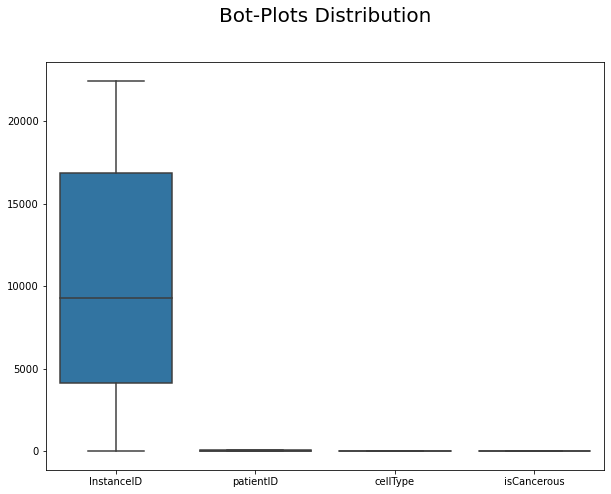

In [15]:
plt.rcParams['figure.figsize'] = [10, 7.5]
# plot the boxplot to see the outlier of each numerical column
sns.boxplot(data=df_label,orient="v")
plt.title("Bot-Plots Distribution", y = 1,fontsize = 20, pad = 40);

### 🔬 Observation:
According to the bot-plots, there are completely no outliner in this dataset

In [16]:
df_label.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


### 📚 Reason: 
After finish cleaning the data, we should display the data to double check the data and figure out the count, mean, min , 25%, 50%, 75%, max to prepare for EDA step in later section.